# Smoothing particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_smoothing as plt_sp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import smoothing_particles as sp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

ordering = True
video_name = "2n_1m_1f_240226_1"
n_particles = int(video_name[0])
save_figures = True
x_bounds = [0, 1080]
y_bounds = [70, 1840]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Load tracked data

In [3]:
df_tracked = pd.read_csv("{}/clustered_{}.csv".format(output_path, video_name), low_memory=False)
df_tracked.head(n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,950.70961,155.828131,935.930138,149.628686,NaN,950.70961,155.828131,NaN,950.70961,155.828131,1.267112,13871.0,241.544270,85.336388,0.935512,2,NaN,NaN,NaN,NaN,False,False,False
1,1,0,1630.74452,540.751409,1625.839777,528.232436,NaN,1630.74452,540.751409,NaN,1630.74452,540.751409,0.205072,15966.0,266.317116,87.001443,0.945134,2,NaN,NaN,NaN,NaN,False,False,False


## Swapping mixed IDs

In [4]:
omega_threshold = 20 * np.pi / 180  # Angular velocity per frame (in degrees)
velocity_threshold = 83  # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
delta = 400

from importlib import reload
reload(sp)

arg_list = [
    # VIDEO 1
    [0    , 10000, velocity_threshold, omega_threshold, True],
    [10000, 20000, velocity_threshold, omega_threshold, True],
    [20000, 30000, velocity_threshold, omega_threshold, True],
    [30000, 40000, velocity_threshold, omega_threshold, True],
    [40000, 50000, velocity_threshold, omega_threshold, True],
    [50000, 60000, velocity_threshold, omega_threshold, True],
    [60000, 70000, velocity_threshold, omega_threshold, True],
    [70000, 80000, velocity_threshold, omega_threshold, True],
    [80000, 90000, velocity_threshold, omega_threshold, True],
    [90000, 100000, velocity_threshold, omega_threshold, True],
    [100000, 111047, velocity_threshold, omega_threshold, True]
]

df_final = sp.smooth_frames(
    df_tracked=df_tracked,
    arg_list=arg_list,
    order=False,
    log_path=log_path,
    log_filename="log_{}".format(video_name),
    verbose=1,
    tqdm_bar=True
)

df_final.head(8)

Thresholds:
	- Velocity: 83 
	- Angle: 20.0 



100%|███████████████████████| 11/11 [00:19<00:00,  1.77s/it]


Time: 30000 Chunks 2 Allowed time 30000 Permutation [0 1]
Time: 60000 Chunks 2 Allowed time 60000 Permutation [0 1]
Time: 90000 Chunks 2 Allowed time 90000 Permutation [0 1]


,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,True,0,chunk_00000_10000,0,0,950.709610,155.828131,935.930138,149.628686,NaN,950.709610,155.828131,NaN,950.709610,155.828131,1.267112,1.267112,13871.0,241.544270,85.336388,0.935512,2,NaN,NaN,NaN,NaN,False,False,False
1,True,0,chunk_00000_10000,1,1,1630.744520,540.751409,1625.839777,528.232436,NaN,1630.744520,540.751409,NaN,1630.744520,540.751409,0.205072,0.205072,15966.0,266.317116,87.001443,0.945134,2,NaN,NaN,NaN,NaN,False,False,False
2,True,3,chunk_00000_10000,0,0,952.512736,157.624286,937.858278,151.103511,NaN,952.512736,157.624286,NaN,952.512736,157.624286,1.252357,1.252357,13662.0,238.162869,86.692448,0.931397,2,3.0,0.601042,0.598719,-0.004918,False,False,False
3,True,3,chunk_00000_10000,1,1,1630.739374,540.933161,1625.912971,528.704340,NaN,1630.739374,540.933161,NaN,1630.739374,540.933161,0.206495,0.206495,15904.0,265.866598,87.052744,0.944875,2,3.0,-0.001715,0.060584,0.000474,False,False,False
4,True,6,chunk_00000_10000,0,0,955.356331,158.696361,940.923193,150.765932,0.0,886.000000,100.000000,0.533333,956.000000,129.000000,1.230812,1.230812,13190.0,237.093417,84.197857,0.934819,2,3.0,0.947865,0.357358,-0.007182,False,False,False
5,True,6,chunk_00000_10000,1,1,1629.923092,540.250095,1625.190793,528.583908,NaN,1629.923092,540.250095,NaN,1629.923092,540.250095,0.222812,0.222812,15798.0,265.829137,87.158400,0.944722,2,3.0,-0.272094,-0.227689,0.005439,False,False,False
6,True,9,chunk_00000_10000,0,0,955.628537,159.695163,941.616875,152.259490,0.0,885.000000,101.000000,0.533333,876.000000,109.000000,1.236371,1.236371,13253.0,235.627684,85.673160,0.931557,2,3.0,0.090735,0.332934,0.001853,False,False,False
7,True,9,chunk_00000_10000,1,1,1629.491582,540.004855,1624.715061,528.257269,NaN,1629.491582,540.004855,NaN,1629.491582,540.004855,0.231715,0.231715,15859.0,266.326787,87.516671,0.944467,2,3.0,-0.143836,-0.081747,0.002968,False,False,False


In [5]:
df_final.tail(5)

,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
74027,True,111039,chunk_100000_111047,1,1,964.613601,196.739005,961.104459,199.085865,NaN,945.372361,169.768293,NaN,1004.795283,178.127021,-1.066266,-1.066266,8736.0,161.941719,73.465014,0.891179,2,3.0,0.0,0.0,0.0,False,False,False
74028,True,111042,chunk_100000_111047,0,0,873.450281,225.333883,862.926082,231.561935,0.0,929.775227,185.431548,0.517647,876.442518,227.372575,1.545826,1.545826,2159.0,94.600781,67.231293,0.703511,2,3.0,0.0,0.0,0.0,False,False,False
74029,True,111042,chunk_100000_111047,1,1,964.613601,196.739005,961.104459,199.085865,NaN,945.372361,169.768293,NaN,1004.795283,178.127021,-1.066266,-1.066266,8736.0,161.941719,73.465014,0.891179,2,3.0,0.0,0.0,0.0,False,False,False
74030,True,111045,chunk_100000_111047,0,0,873.450281,225.333883,862.926082,231.561935,0.0,929.775227,185.431548,0.517647,876.442518,227.372575,1.545826,1.545826,2159.0,94.600781,67.231293,0.703511,2,3.0,0.0,0.0,0.0,False,False,False
74031,True,111045,chunk_100000_111047,1,1,964.613601,196.739005,961.104459,199.085865,NaN,945.372361,169.768293,NaN,1004.795283,178.127021,-1.066266,-1.066266,8736.0,161.941719,73.465014,0.891179,2,3.0,0.0,0.0,0.0,False,False,False


## Interpolation over not allowed frames

In [6]:
if ordering:
    df_full = df_final.copy().sort_values(["time", "permuted_id"])
    for id_ in range(len(df_full["permuted_id"].unique())):
        mask = df_full.loc[:,"permuted_id"]==df_full["permuted_id"].unique()[id_]
        df_full[mask]=df_full[mask].interpolate(method="linear")

In [7]:
if ordering:
    cols = [
        "id", "permuted_id", "time", "position_x", "position_y", "weighted_x", "weighted_y",
        "darkest_v", "darkest_x", "darkest_y", "lightest_v", "lightest_x", "lightest_y",
        "orientation", "corrected_orientation", "area", "axis_major", "axis_minor", "eccentricity"
    ]
    df_temp = df_full[cols]
    df_temp.to_csv("{}/interpolated_{}.csv".format(output_path, video_name), index=False)
    df_temp

Thresholds:
	- Velocity: 6.659425733416189 
	- Angle: 9.121589531188496 



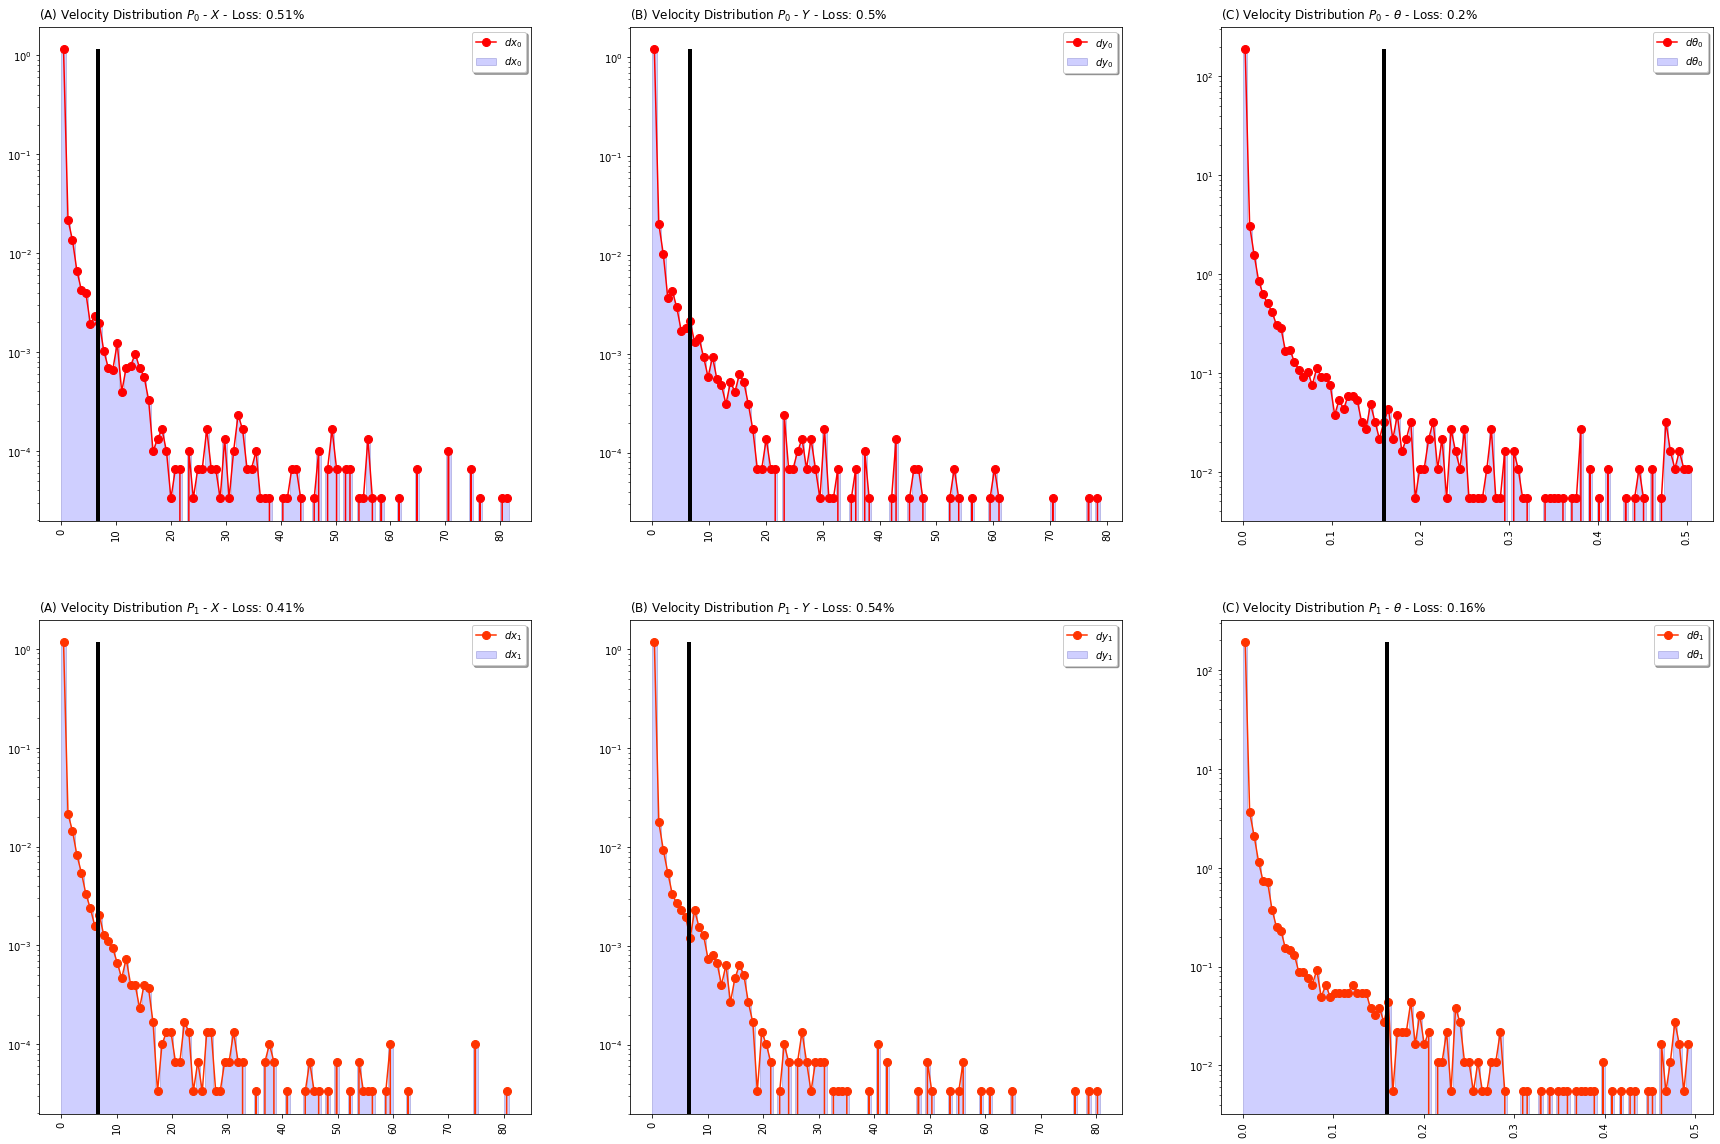

In [8]:
if ordering:
    bins = 100
    width = 10
    fancy_legend = True
    omega_threshold = df_full["velocity_orientation"].abs().quantile(0.9965) # Angular velocity per frame
    velocity_threshold = df_full["velocity_x"].abs().quantile(0.9901) # Velocity per frame limited with half average size of particle
    print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    df_smooth["orientation"] = df_smooth["corrected_orientation"]
    plt_cp.plot_velocities_distribution(
        df_tracked=df_smooth,
        bins=bins,
        velocity_threshold=velocity_threshold,
        omega_threshold=omega_threshold,
        width=width,
        fancy_legend=fancy_legend
    )

Original


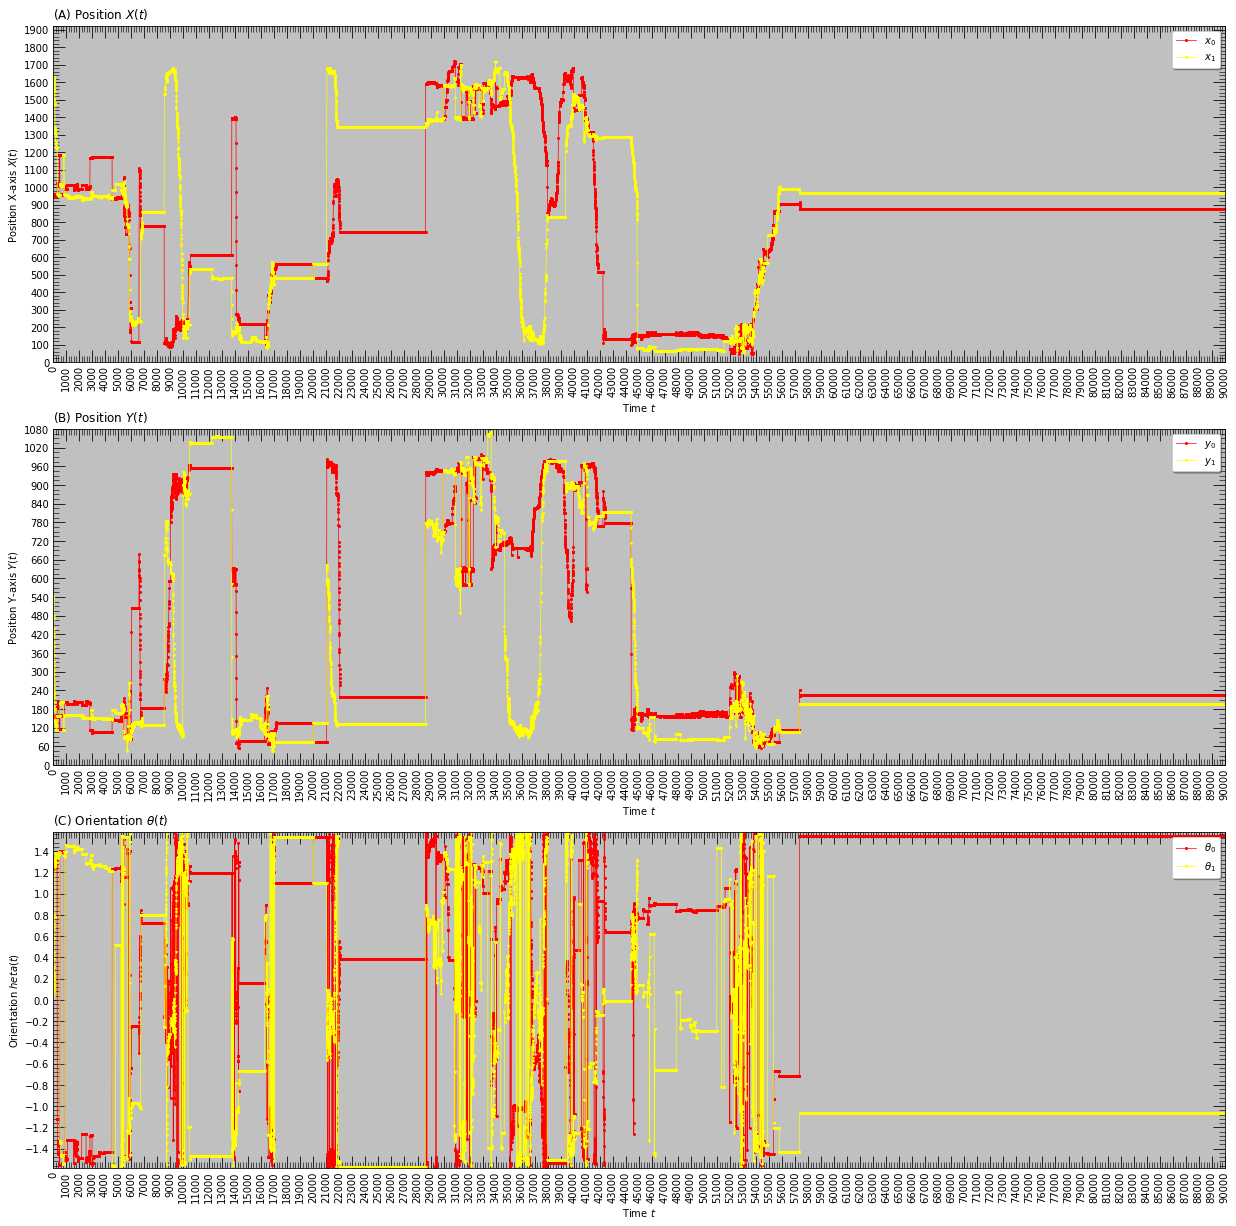

Corrected Orientation


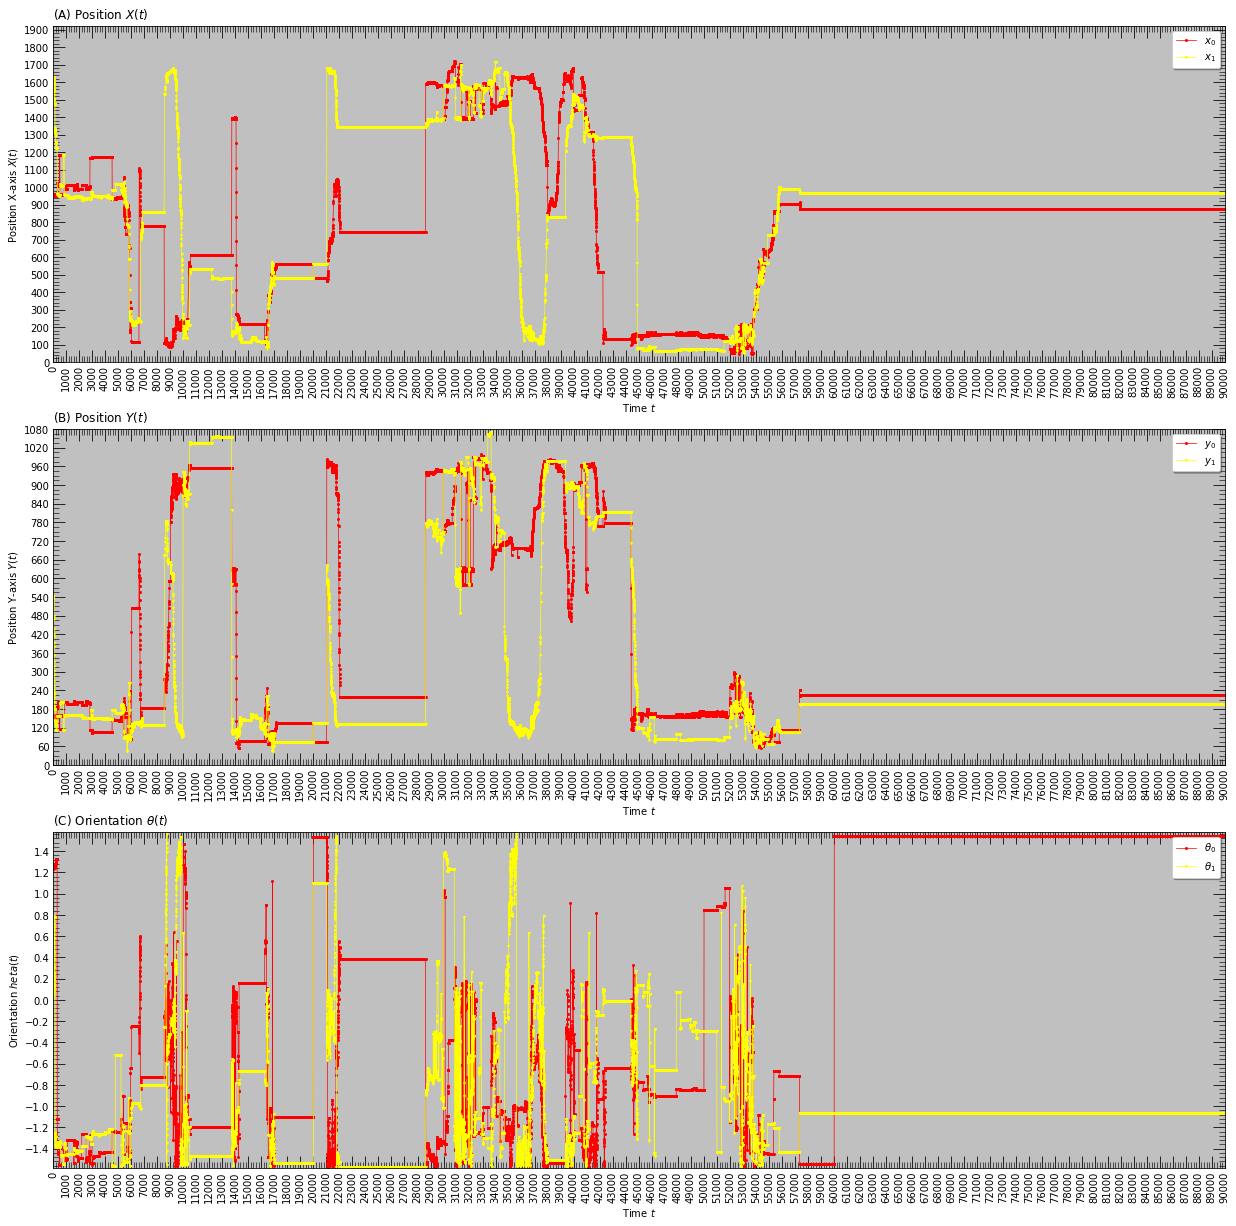

In [9]:
if ordering:
    width = 21
    n_x_breaks = 100
    n_y_breaks = 20
    t0, tf   = 0, 90000  # 22200, 24300
    t0_, tf_ = 0, 90000  # 22200, 24300
    t_bounds = [t0_, tf_]
    p_bounds = [[0, 1920], [0, 1080], [-1.58, 1.58]]
    fancy_legend = True

    print("Original")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    velocity_threshold = df_full["velocity_x"].abs().quantile(0.9701) # Velocity per frame limited with half average size of particle
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[((df_smooth["velocity_x"] <= velocity_threshold) & (df_smooth["velocity_y"] <= velocity_threshold))],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend
    )

    print("Corrected Orientation")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    df_smooth["orientation"] = df_smooth["corrected_orientation"]
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[((df_smooth["velocity_x"] <= velocity_threshold) & (df_smooth["velocity_y"] <= velocity_threshold))],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend
    )

## Setting video information

In [10]:
# # Load the video
# reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# # Check the number of frames
# num_frames = reader.count_frames()
# print("Total frames: {}".format(num_frames))

# # Extract a frame to inspect the content
# time = 0
# frame = reader.get_data(time)
# print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

## Comparative of process

In [11]:
# # Original frame
# time = 209  #271  # 209  # 80
# times = [time - 1, time, time + 1]
# reinforce_boundaries = True
# remove_holes = False
# type = "local equalized"
# clip_limit = 0.05
# threshold = 0.19
# sigma = 1.5
# x_bounds = x_bounds  # [40, 1020]
# y_bounds = y_bounds  # [160, 1740]
# region_area_min = 200
# axis_major_min = 94
# eccentricity_max = 0.99


# df_tracked_frame_0 = tp.process_frame(
#     reinforce_boundaries=reinforce_boundaries,
#     remove_holes=remove_holes,
#     type=type,
#     clip_limit=clip_limit,
#     threshold=threshold,
#     sigma=sigma,
#     x_bounds=x_bounds,
#     y_bounds=y_bounds,
#     region_area_min=region_area_min,
#     axis_major_min=axis_major_min,
#     eccentricity_max=eccentricity_max,
#     tracking_list=[times[0], reader.get_data(times[0])]
# )

# df_tracked_frame_1 = tp.process_frame(
#     reinforce_boundaries=reinforce_boundaries,
#     remove_holes=remove_holes,
#     type=type,
#     clip_limit=clip_limit,
#     threshold=threshold,
#     sigma=sigma,
#     x_bounds=x_bounds,
#     y_bounds=y_bounds,
#     region_area_min=region_area_min,
#     axis_major_min=axis_major_min,
#     eccentricity_max=eccentricity_max,
#     tracking_list=[times[1], reader.get_data(times[1])]
# )

# df_tracked_frame_2 = tp.process_frame(
#     reinforce_boundaries=reinforce_boundaries,
#     remove_holes=remove_holes,
#     type=type,
#     clip_limit=clip_limit,
#     threshold=threshold,
#     sigma=sigma,
#     x_bounds=x_bounds,
#     y_bounds=y_bounds,
#     region_area_min=region_area_min,
#     axis_major_min=axis_major_min,
#     eccentricity_max=eccentricity_max,
#     tracking_list=[times[2], reader.get_data(times[2])]
# )

# df_tracked_old = pd.concat([df_tracked_frame_0, df_tracked_frame_1, df_tracked_frame_2], ignore_index=True)

# width = 10
# n_x_breaks = 20
# n_y_breaks = 20
# fancy_legend = True
# x_legend = 1.001
# y_legend = 0.891

# df_smooth = df_full.copy()
# df_smooth["id"] = df_smooth["permuted_id"]
# df_smooth["orientation"] = df_smooth["corrected_orientation"]

# fig = plt_sp.plot_all_process_frame(
#     reader=reader,
#     times=times,
#     df_tracked=df_tracked_old,
#     df_clustered=df_tracked,
#     df_smoothed=df_smooth,
#     width=width,
#     n_x_breaks=n_x_breaks,
#     n_y_breaks=n_y_breaks,
#     x_bounds=x_bounds,
#     y_bounds=y_bounds,
#     fancy_legend=fancy_legend,
#     x_legend=x_legend,
#     y_legend=y_legend
# )